In [1]:
from helper_functions import *
from plots import *

xp = gwpop.cupy_utils.xp

In [2]:
luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)
luminosity_prior = luminosity_distances ** 2
dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

### Posteriors

In [3]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

In [4]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))

PRIOR_VOLUME = (
    (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2
    * (BOUNDS["a_1"][1] - BOUNDS["a_1"][0])
    * (BOUNDS["a_2"][1] - BOUNDS["a_2"][0])
    * (BOUNDS["cos_tilt_1"][1] - BOUNDS["cos_tilt_1"][0])
    * (BOUNDS["cos_tilt_2"][1] - BOUNDS["cos_tilt_2"][0])) / 2

for posterior in posteriors:
    del posterior["chi_eff"]
    del posterior["chi_p"]
    del posterior["joint_prior"]
    posterior["spin_prior"] = 1/4
    posterior["mass_spin_prior"] = (posterior["mass_1"] * (1 + posterior["redshift"])**2)/PRIOR_VOLUME
    posterior["redshift_prior"] = redshift_prior(posterior['redshift'])

### Default Spin Model without selection effects

In [5]:
model = bilby.hyper.model.Model([spin.iid_spin_default])

for posterior in posteriors:
    posterior["prior"] = posterior["spin_prior"]

In [6]:
def prior_conversion1(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters

def prior_conversion2(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    added_keys = pd.DataFrame()
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    added_keys["alpha_chi"] = parameters["alpha_chi"]
    added_keys["beta_chi"] = parameters["beta_chi"]
    return parameters, added_keys

In [7]:
priors = PriorDict(conversion_function = prior_conversion1)

# spin magnitude 
priors["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priors["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priors["amax"] = 1
priors["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priors["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priors["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label=r'$\zeta$')
priors["sigma_spin"] = Uniform(minimum = 0.01, maximum = 4, latex_label=r'$\sigma_t$')

In [8]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    conversion_function = prior_conversion2)

In [9]:
for ii in range(10):
    likelihood.parameters.update(priors.sample())
    print(likelihood.parameters)
    print(likelihood.log_likelihood_ratio())

{'mu_chi': 0.5858967801538438, 'sigma_chi': 0.06928382018775206, 'amax': 1.0, 'xi_spin': 0.8580368794264814, 'sigma_spin': 2.50723570962951, 'alpha_chi': 1.465827529029368, 'beta_chi': 1.0360253206218513}
-3.6029525851574533
{'mu_chi': 0.5919841831624716, 'sigma_chi': 0.04524340395046081, 'amax': 1.0, 'xi_spin': 0.5005395059639909, 'sigma_spin': 3.729053044912557, 'alpha_chi': 2.568414944260453, 'beta_chi': 1.770239731510749}
-4.077326431605415
{'mu_chi': 0.46113023608228476, 'sigma_chi': 0.016278938252779457, 'amax': 1.0, 'xi_spin': 0.577282855076584, 'sigma_spin': 2.6321737559652494, 'alpha_chi': 6.577772097891068, 'beta_chi': 7.686684194923616}
5.950950684873184
{'mu_chi': 0.6704322840993946, 'sigma_chi': 0.037854466404518505, 'amax': 1.0, 'xi_spin': 0.46646407468524276, 'sigma_spin': 3.4206609202008407, 'alpha_chi': 3.2428157140241054, 'beta_chi': 1.594086969414306}
-11.885548894181778
{'mu_chi': 0.31765698181214574, 'sigma_chi': 0.032005548151651964, 'amax': 1.0, 'xi_spin': 0.7352

In [10]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty', 
                           nlive = 1000, label='default_spin', 
                           outdir = 'Results/default_spin', clean = True)

05:54 bilby INFO    : Running for label 'default_spin', output will be saved to 'Results/default_spin'
05:54 bilby INFO    : Search parameters:
05:54 bilby INFO    :   mu_chi = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\mu_\\chi$', unit=None, boundary=None)
05:54 bilby INFO    :   sigma_chi = Uniform(minimum=0, maximum=0.25, name=None, latex_label='$\\sigma^2_\\chi$', unit=None, boundary=None)
05:54 bilby INFO    :   xi_spin = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\zeta$', unit=None, boundary=None)
05:54 bilby INFO    :   sigma_spin = Uniform(minimum=0.01, maximum=4, name=None, latex_label='$\\sigma_t$', unit=None, boundary=None)
05:54 bilby INFO    :   alpha_chi = Constraint(minimum=1, maximum=100000.0, name=None, latex_label=None, unit=None)
05:54 bilby INFO    :   beta_chi = Constraint(minimum=1, maximum=100000.0, name=None, latex_label=None, unit=None)
05:54 bilby INFO    :   amax = 1
05:54 bilby INFO    : Single likelihood evaluation took 7.348e-03 

0it [00:00, ?it/s]

05:54 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f3642540760>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
05:54 bilby INFO    : Checkpoint every check_point_delta_t = 600s
05:54 bilby INFO    : Using dynesty version 1.0.1
05:54 bilby INFO    : Using the bilby-implemented rwalk sam

07:52 bilby INFO    : Sampling time: 1:57:40.439792
07:52 bilby INFO    : Summary of results:
nsamples: 13700
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.110
ln_bayes_factor: 11.525 +/-  0.110



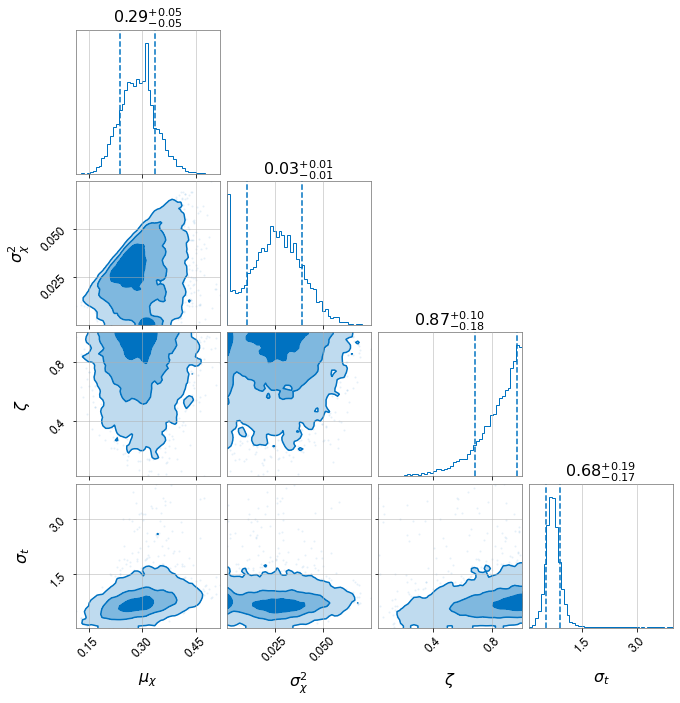

In [11]:
result.plot_corner()

In [37]:
import matplotlib.lines as mlines
    
def overlayed_plot_default(result_O3a_file, result1_file, filename, label1 = "", label2 = "", save = False):
    with open(result_O3a_file,'r') as ff1:
        data1 = json.load(ff1)
        
    plot_data1 = {
        'xi_spin':{'data':data1['posterior']['content']['xi_spin'],'plot_bounds':(0.,1.),'priors':(0.,1.),'label':r'$\zeta$'},
        'mu_chi':{'data':data1['posterior']['content']['mu_chi'],'plot_bounds':(0.,0.6),'priors':(0.,1.),'label':r'$\mu_\chi$'},
        'sigma_chi':{'data':data1['posterior']['content']['sigma_chi'],'plot_bounds':(0.,0.1),'priors':(0.,.25),'label':r'$\sigma^2_\chi$'},
        'sigma_spin':{'data':data1['posterior']['content']['sigma_spin'],'plot_bounds':(0.,4.),'priors':(0.,4.),'label':r'$\sigma_t$'}}
    
    with open(result1_file,'r') as ff2:
        data2 = json.load(ff2)
        
    plot_data2 = {
        'xi_spin':{'data':data2['posterior']['content']['xi_spin'],'plot_bounds':(0.,1.),'priors':(0.,1.),'label':r'$\zeta$'},
        'mu_chi':{'data':data2['posterior']['content']['mu_chi'],'plot_bounds':(0.,0.6),'priors':(0.,1.),'label':r'$\mu_\chi$'},
        'sigma_chi':{'data':data2['posterior']['content']['sigma_chi'],'plot_bounds':(0.,0.1),'priors':(0.,.25),'label':r'$\sigma^2_\chi$'},
        'sigma_spin':{'data':data2['posterior']['content']['sigma_spin'],'plot_bounds':(0.,4.),'priors':(0.,4.),'label':r'$\sigma_t$'}}

    colors = ["#ff7f00", "#FF0000"]
    labels = [label1, label2]
    
    fig = plt.figure(figsize=(8,8))
    plot_corner(fig, plot_data1, colors[0], bins=25, hist_alpha=0.75)
    plot_corner(fig, plot_data2, colors[1], bins=25, hist_alpha=0.75)
                                             
    line1 = mlines.Line2D([],[], color = colors[0], label = label1, lw = 2)
    line2 = mlines.Line2D([],[], color = colors[1], label = label2, lw = 2)
    fig.legend(handles=[line1, line2], frameon = False, fontsize=12, handlelength = 5)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.18, hspace=0.16)
    if save == True:
        filename = "./Results/Overlayed_Plots_Default/" + filename
        fig.savefig(filename, dpi=400)
    plt.show()

xi_spin mu_chi 0.02609994763971855
xi_spin sigma_chi 0.02327091797992632
xi_spin sigma_spin 0.04342188749774395
mu_chi sigma_chi 0.011227200943100958
mu_chi sigma_spin 0.020949163100760417
sigma_chi sigma_spin 0.018678438094795795


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin mu_chi 0.020665910293086873
xi_spin sigma_chi 0.020811485778212967
xi_spin sigma_spin 0.02260706509925596


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.012283918089751366
mu_chi sigma_spin 0.013343753487300646


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi sigma_spin 0.013437749994580878


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


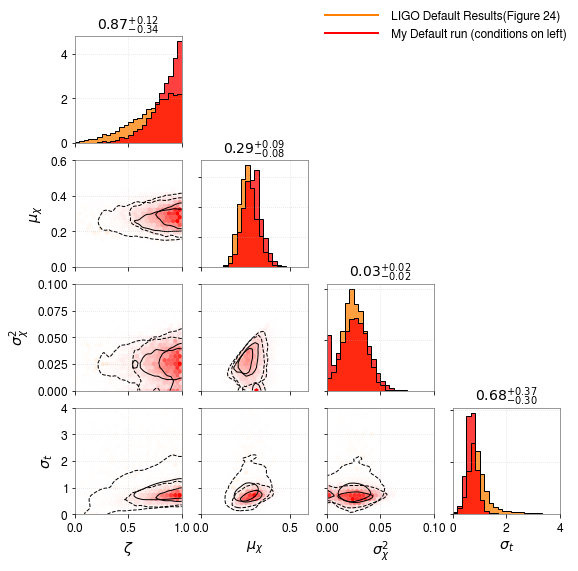

In [38]:
overlayed_plot_default("Results/O3a_LIGO_default_results/O3a_LIGO_default_results.json", 
                       "Results/default_spin/default_spin_result.json", "default_spin", 
                       "LIGO Default Results(Figure 24)", "My Default run (conditions on left)", save = True)

xi_spin mu_chi 0.02609994763971855
xi_spin sigma_chi 0.02327091797992632
xi_spin sigma_spin 0.04342188749774395
mu_chi sigma_chi 0.011227200943100958
mu_chi sigma_spin 0.020949163100760417
sigma_chi sigma_spin 0.018678438094795795


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin mu_chi 0.020665910293086873
xi_spin sigma_chi 0.020811485778212967
xi_spin sigma_spin 0.02260706509925596


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.012283918089751366
mu_chi sigma_spin 0.013343753487300646


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi sigma_spin 0.013437749994580878


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


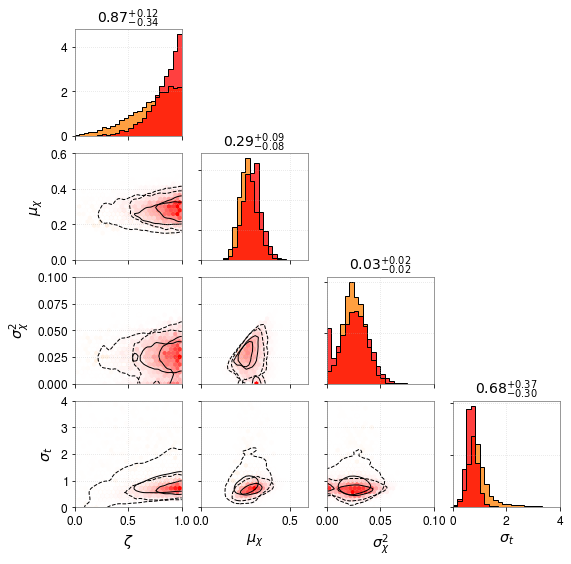

In [12]:
overlayed_plot_default("Results/O3a_LIGO_default_results/O3a_LIGO_default_results.json", 
                       "Results/default_spin/default_spin_result.json", "default_spin", save = True)